# Import Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.9 MB/s 
     |████████████████████████████████| 163 kB 49.5 MB/s 


In [2]:
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoModelForMaskedLM, RobertaTokenizerFast
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd

# Define the Templates for Prior Estimation

In [3]:
# define the templates to fill

prior_templates = [
    '<mask> is a <mask>.',
    '<mask> is an <mask>.',
    '<mask> works as a <mask>.',
    '<mask> works as an <mask>.'
]

# define the filler tokens (pronouns)

tokens = ['He', 'She']

# The Publicly Released roberta-base

In [4]:
# load the model

model = AutoModelForMaskedLM.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# prepare the unmasker
unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# use the unmasker to get the result
results = unmasker(prior_templates, targets=tokens)

In [6]:
# initialize the empty dataframe to save results
prior = pd.DataFrame(columns=['pronoun', 'score', 'occupation', 'template',
                              'sentence', 'model', 'seed', 'checkpoint'])

# loop over templates and their results
for result, template in zip(results, prior_templates):

    # just take the first masked token
    for r in result[0][:2]:

        # fill in the data
        new_row = dict()
        new_row['pronoun'] = r['token_str']
        new_row['score'] = r['score']
        new_row['occupation'] = '<mask>'
        new_row['template'] = template
        new_row['sentence'] = r['sequence']
        new_row['model'] = 'roberta-base'
        new_row['seed'] = -1 # default model
        # no checkpoint

        # append the data
        prior.loc[len(prior.index)] = new_row

# preview the results
display(prior)

,pronoun,score,occupation,template,sentence,model,seed,checkpoint
0,He,0.022583,<mask>,<mask> is a <mask>.,<s>He is a<mask>.</s>,roberta-base,-1,NaN
1,She,0.007527,<mask>,<mask> is a <mask>.,<s>She is a<mask>.</s>,roberta-base,-1,NaN
2,He,0.009232,<mask>,<mask> is an <mask>.,<s>He is an<mask>.</s>,roberta-base,-1,NaN
3,She,0.002968,<mask>,<mask> is an <mask>.,<s>She is an<mask>.</s>,roberta-base,-1,NaN
4,He,0.059290,<mask>,<mask> works as a <mask>.,<s>He works as a<mask>.</s>,roberta-base,-1,NaN
5,She,0.035035,<mask>,<mask> works as a <mask>.,<s>She works as a<mask>.</s>,roberta-base,-1,NaN
6,He,0.142797,<mask>,<mask> works as an <mask>.,<s>He works as an<mask>.</s>,roberta-base,-1,NaN
7,She,0.096930,<mask>,<mask> works as an <mask>.,<s>She works as an<mask>.</s>,roberta-base,-1,NaN


# Custom RoBERTa Checkpoints

In [7]:
# save the checkpoint numbers, from 0 to 1,000,000 for roberta
checkpoints = []

# read in numbers
with open('/content/drive/MyDrive/roberta-checkpoints/steps.txt', 'r') as f:
    for line in f:
        checkpoints.append(int(line))

# check if numbers are correct
print(checkpoints)

[0, 10, 20, 40, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000, 320000, 340000, 360000, 380000, 400000, 420000, 440000, 460000, 480000, 500000, 520000, 540000, 560000, 580000, 600000, 620000, 640000, 660000, 680000, 700000, 720000, 740000, 760000, 780000, 800000, 820000, 840000, 860000, 880000, 900000, 920000, 940000, 960000, 980000, 1000000]


In [8]:
# loop over checkpoints, total = 62
for checkpoint in tqdm(checkpoints):
    
    # read model and prepare unmasker
    model = AutoModelForMaskedLM.from_pretrained(f'/content/drive/MyDrive/roberta-checkpoints/checkpoint-{checkpoint}')
    tokenizer = RobertaTokenizerFast.from_pretrained(f'/content/drive/MyDrive/roberta-checkpoints/checkpoint-{checkpoint}')

    unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)

    # get results
    results = unmasker(prior_templates, targets=tokens)

    # loop over templates and their results
    for result, template in zip(results, prior_templates):

        # just take the first masked token
        for r in result[0][:2]:

            # fill in the data
            new_row = dict()
            new_row['pronoun'] = r['token_str']
            new_row['score'] = r['score']
            new_row['occupation'] = '<mask>'
            new_row['template'] = template
            new_row['sentence'] = r['sequence']
            new_row['model'] = 'roberta-base'
            new_row['seed'] = 0 # the only available roberta pre-training process
            new_row['checkpoint'] = checkpoint

            # append the data
            prior.loc[len(prior.index)] = new_row

100%|██████████| 62/62 [07:26<00:00,  7.20s/it]


# Check and Save results

In [9]:
# check head
prior.head()

,pronoun,score,occupation,template,sentence,model,seed,checkpoint
0,He,0.022583,<mask>,<mask> is a <mask>.,<s>He is a<mask>.</s>,roberta-base,-1,NaN
1,She,0.007527,<mask>,<mask> is a <mask>.,<s>She is a<mask>.</s>,roberta-base,-1,NaN
2,He,0.009232,<mask>,<mask> is an <mask>.,<s>He is an<mask>.</s>,roberta-base,-1,NaN
3,She,0.002968,<mask>,<mask> is an <mask>.,<s>She is an<mask>.</s>,roberta-base,-1,NaN
4,He,0.059290,<mask>,<mask> works as a <mask>.,<s>He works as a<mask>.</s>,roberta-base,-1,NaN


In [10]:
# check tail
prior.tail()

,pronoun,score,occupation,template,sentence,model,seed,checkpoint
499,She,0.008836,<mask>,<mask> is an <mask>.,<s>She is an<mask>.</s>,roberta-base,0,1000000.0
500,He,0.038524,<mask>,<mask> works as a <mask>.,<s>He works as a<mask>.</s>,roberta-base,0,1000000.0
501,She,0.020888,<mask>,<mask> works as a <mask>.,<s>She works as a<mask>.</s>,roberta-base,0,1000000.0
502,He,0.036690,<mask>,<mask> works as an <mask>.,<s>He works as an<mask>.</s>,roberta-base,0,1000000.0
503,She,0.020721,<mask>,<mask> works as an <mask>.,<s>She works as an<mask>.</s>,roberta-base,0,1000000.0


In [11]:
# check length
# 8 for each checkpoint, total 1+62=63 model checkpoints, should get 504

len(prior.index)

504

In [12]:
# save after checking correctness

# file name, save in the data subfolder
out_file = '/content/drive/MyDrive/checkpoint-bias/data/roberta-prior.pkl'

# save file
prior.to_pickle(out_file)

# Generate Plots

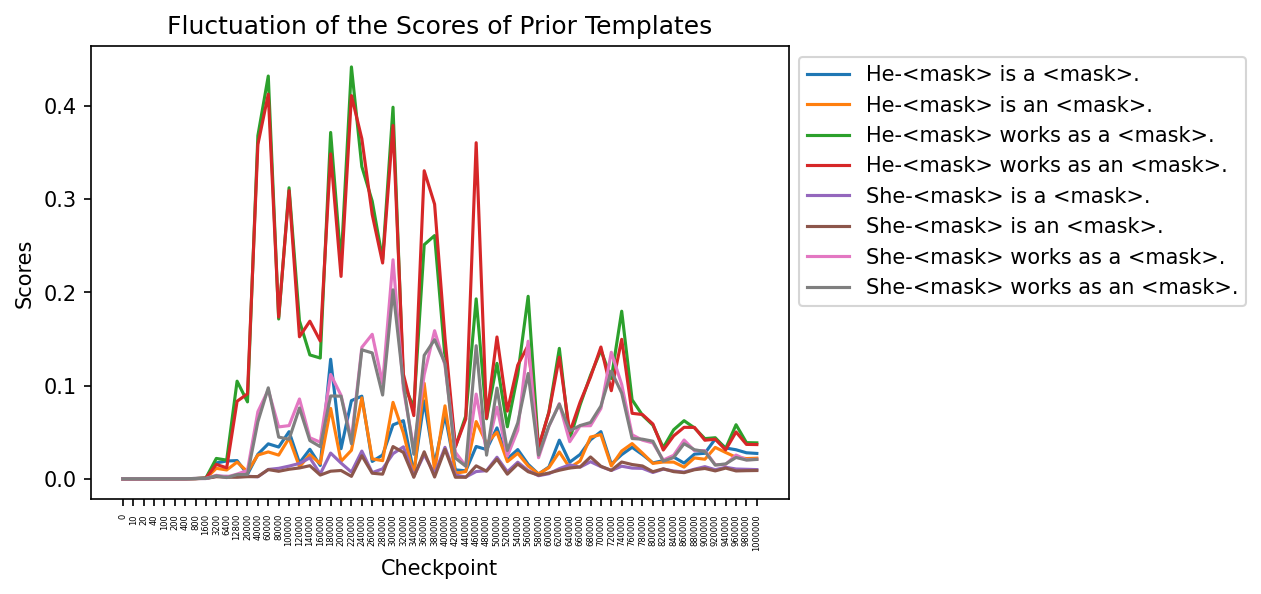

In [13]:
# plot the 8 lines of probability fluctuations of the custom model

# initialize plot
fig, ax = plt.subplots(dpi=150)

# loop over 2 tokens (pronouns)
for token in tokens:

    # loop over 4 templates
    for template in prior_templates:

        # get the sequence of probabilities, guaranteed to be in correct order
        scores = prior[
            (prior['pronoun'] == token) & # 1 of the 2 pronouns
            (prior['template'] == template) & # 1 of the 4 templates
            (prior['seed'] == 0) # the custom roberta
        ]['score']

        ax.plot(range(len(scores)), scores, label = f'{token}-{template}')

ax.set_xlabel('Checkpoint')
ax.set_ylabel('Scores')

ax.set_xticks(range(len(checkpoints)))
ax.set_xticklabels(checkpoints, rotation = 90, fontsize=4)

ax.set_title('Fluctuation of the Scores of Prior Templates')
ax.legend(bbox_to_anchor=[1, 1], loc = 'upper left')

plt.show()

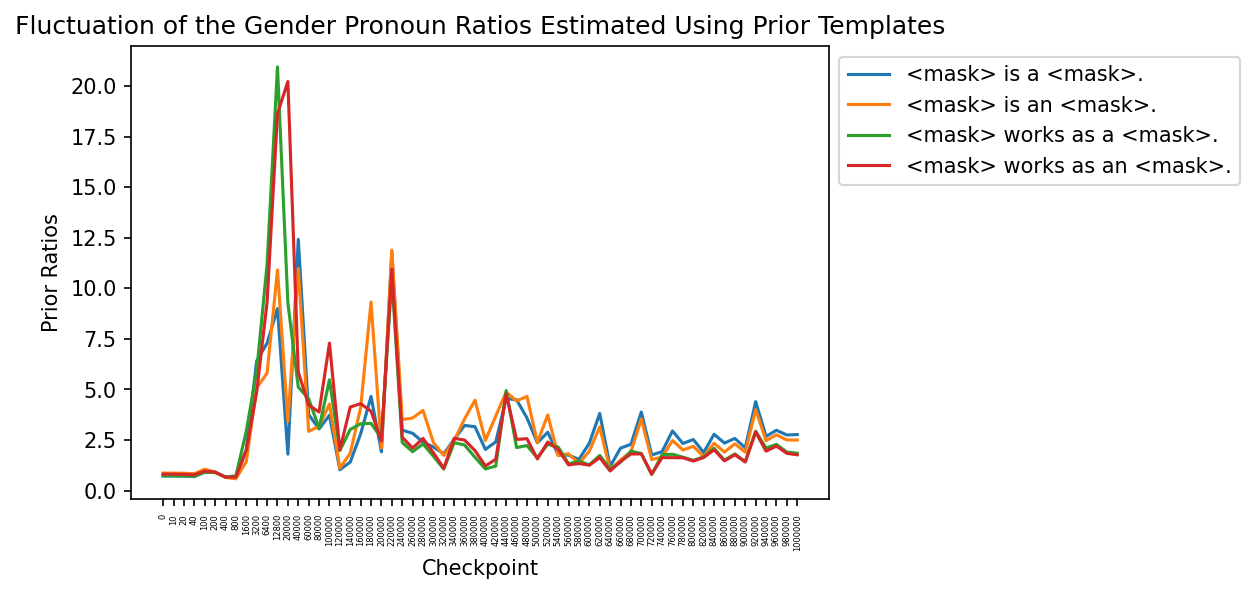

In [14]:
# plot the 4 lines of ratio fluctuations of the custom model

# initialize plot
fig, ax = plt.subplots(dpi=150)

# loop over 4 templates
for template in prior_templates:

    # get the sequence of probabilities for he
    he_scores = prior[
        (prior['pronoun'] == 'He') & # he
        (prior['template'] == template) & # 1 of the 4 templates
        (prior['seed'] == 0) # the custom roberta
    ]['score']

    # get the sequence of probabilities for she
    she_scores = prior[
        (prior['pronoun'] == 'She') & # she
        (prior['template'] == template) & # 1 of the 4 templates
        (prior['seed'] == 0) # the custom roberta
    ]['score']

    # calculate ratios of he/she
    ratios = np.array(he_scores) / np.array(she_scores)

    ax.plot(range(len(scores)), ratios, label = f'{template}')

ax.set_xlabel('Checkpoint')
ax.set_ylabel('Prior Ratios')

ax.set_xticks(range(len(checkpoints)))
ax.set_xticklabels(checkpoints, rotation = 90, fontsize=4)

ax.set_title('Fluctuation of the Gender Pronoun Ratios Estimated Using Prior Templates')
ax.legend(bbox_to_anchor=[1, 1], loc='upper left')

plt.show()